# density-随机森林拟合-7-10月

要点梳理：
- 剔除云层遮挡和数据缺失的情况

拖山的经度和纬度是(120.14,31.406)，兰山嘴的经度和纬度是(119.89,31.212)。我需要分析这2个点位逐日的叶绿素a浓度，请你修改下面的代码。如果受到云层影响导致数据缺失，请你用NAN代替。

创新点在于，将云层覆盖的区域设置为999999，这样在后续处理中可以很容易地识别出这些区域。

https://engine-aiearth.aliyun.com/docs/page/api?d=07f36f#heading-22

https://engine-aiearth.aliyun.com/?spm=a2cvf.28031243.0.0.5dc743d42pbV5o#/utility/auth-token

In [1]:
import aie

aie.Authenticate(token='8f04bf5ebc3b343fcfc4373fd0dd4a33')
aie.Initialize()

计算资源初始化中，请等待...
计算资源初始化完成.


In [2]:
import geopandas as gpd

In [3]:
# 读取shp文件
shapefile_path = '/root/Download/Modis-algae-aliyun/local-data/taihu.shp'
gdf = gpd.read_file(shapefile_path)

# 假设shp文件中只有一个几何对象，取第一个
geometry = gdf.geometry.iloc[0]
print(geometry)
# 输出((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, ...

# 将geopandas的geometry对象转换为ee.Geometry
coords = list(geometry.exterior.coords)
flattened_coords = [coord for point in coords for coord in point]
taihu = aie.Geometry.Polygon(flattened_coords)
# 构造Polygon。输入参数支持GeoJSON 'Polygon'类型格式的坐标点集，
# 同时也支持包含偶数个数字的一维List，例如aie.Geometry.Polygon([aLng, aLat, bLng, bLat, ...])。
# 需注意，输入的坐标点将以EPSG:4326坐标系进行解析。

# 打印ee.Geometry对象以验证
print(taihu)

POLYGON ((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, 120.00611934273043 31.40820067954559, 120.0213482061359 31.420557311454473, 120.02780893606551 31.42562749019076, 120.03023170978913 31.42966374717613, 120.0274051404449 31.43596389857637, 120.02025218945138 31.447873965243872, 120.00888822698595 31.45166321445573, 120.01067646473432 31.455403102339847, 120.01448368058568 31.46224277412878, 120.01806015608244 31.467556706624215, 120.02342486932757 31.473017934057427, 120.02827041677476 31.47729813281918, 120.02902032292732 31.479561147303205, 120.03525031250228 31.481725718642263, 120.03871141782174 31.48452974796941, 120.04223020822982 31.48275879185581, 120.04678733023371 31.479659537995836, 120.05734370145801 31.476461787529658, 120.06017027080222 31.47651098451827, 120.06380443138762 31.471541958062947, 120.06276609979179 31.468442332717288, 120.06345832085567 31.46578542930369, 120.06703479635243 31.4656870240255, 120.07078432711515 31.46052060

# 计算完整的7月份

你这个逻辑还是有问题，请你用伪代码的方式，提供一个代码的逻辑框架，please think by chain-of-thought：


我需要你同步输出modis反演的藻密度和lanshanzui.csv'中的藻密度，使得二者之间的差距尽可能小。由于lanshanzui.csv'中的藻密度一天会产生6个值，因此lanshanzui.csv'中的藻密度将采用置信区间的形式，modis反演的藻密度将与“lanshanzui.csv'中的藻密度将采用置信区间”进行比较

请你分析并修改这段代码，我的顾虑是："""这段代码好像是通过2022年7月逐日的计算值逐步优化参数，应该根据遥感影像的sample的完整的2022年7月的结果一起计算？输出一个最终的优化参数？"""

需要你注意如下2种情况将不作为参数优化的计算依据：
- MODIS遥感影像中藻密度为9999.0，也就是云层遮挡的情况
- df['density']中数据缺失的情况。


## demo-1.0版本-计算失败

In [18]:
pip install scikit-learn -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [12]:
import datetime
import csv
import aie
import pandas as pd
import numpy as np
import chardet
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# 步骤1: 数据准备
csv_file = '/root/Download/Modis-algae-aliyun/aie-taihu/00-lanshanzui.csv'

# 检测文件编码
with open(csv_file, 'rb') as f:
    result = chardet.detect(f.read())

# 使用探测到的编码读取文件
df = pd.read_csv(csv_file, encoding=result['encoding'])

# 将日期列转换为日期时间格式
df['date'] = pd.to_datetime(df['date'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 对密度列进行线性插值
df['density'] = df['density'].interpolate(method='linear')

# 按日期分组并计算每日的统计数据
daily_stats = df['density'].resample('D').agg(['mean', 'std', 'count'])

# 计算95%置信区间
confidence_interval = 1.96 * daily_stats['std'] / np.sqrt(daily_stats['count'])

# 计算置信区间的上下限
daily_stats['lower_ci'] = daily_stats['mean'] - confidence_interval
daily_stats['upper_ci'] = daily_stats['mean'] + confidence_interval

# 步骤2: 收集所有有效数据
valid_features = {
    'ndci': [],
    'ndvi': [],
    'evi': [],
    'ndwi': [],
    'b1': [],
    'b2': [],
    'b5': []
}
valid_density_mean = []
valid_density_lower = []
valid_density_upper = []
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2023, 12, 31)
delta = datetime.timedelta(days=1)
roi = aie.Geometry.BBox(119.89, 31.212, 119.90, 31.222)

def mask_clouds(image):
    qa = image.select('state_1km')
    cloud_bit_mask = 1 << 10
    mask = qa.bitwiseAnd(aie.Image.constant(cloud_bit_mask))
    return mask

In [20]:
from aiearth.core.error.aie_error import AIEError
from requests.exceptions import ReadTimeout
import pickle

# 加载已保存的数据（如果存在）
try:
    with open('saved_data.pkl', 'rb') as f:
        saved_data = pickle.load(f)
    valid_features = saved_data['valid_features']
    valid_density_mean = saved_data['valid_density_mean']
    valid_density_lower = saved_data['valid_density_lower']
    valid_density_upper = saved_data['valid_density_upper']
    start_date = saved_data['start_date']
    print("已加载保存的数据，从", start_date, "继续")
except FileNotFoundError:
    print("未找到保存的数据，从头开始")

while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    try:
        img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
                 .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
        
        cloud_mask = mask_clouds(img)
        ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
        ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
        evi = img.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
        ).rename(['evi'])
        ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
        
        ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(9999))
        ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(9999))
        evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(9999))
        ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(9999))
        b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(9999))
        b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(9999))
        b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(9999))
        
        current_date = pd.to_datetime(start_date)
        if current_date in daily_stats.index:
            mean_density = daily_stats.loc[current_date, 'mean']
            lower_ci = daily_stats.loc[current_date, 'lower_ci']
            upper_ci = daily_stats.loc[current_date, 'upper_ci']
            
            ndci_values = ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo()
            ndvi_values = ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo()
            evi_values = evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo()
            ndwi_values = ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo()
            b1_values = b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo()
            b2_values = b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo()
            b5_values = b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
            
            valid_indices = [i for i in range(len(ndci_values)) if ndci_values[i] != 9999.0]
            
            if valid_indices:
                valid_features['ndci'].extend([ndci_values[i] for i in valid_indices])
                valid_features['ndvi'].extend([ndvi_values[i] for i in valid_indices])
                valid_features['evi'].extend([evi_values[i] for i in valid_indices])
                valid_features['ndwi'].extend([ndwi_values[i] for i in valid_indices])
                valid_features['b1'].extend([b1_values[i] for i in valid_indices])
                valid_features['b2'].extend([b2_values[i] for i in valid_indices])
                valid_features['b5'].extend([b5_values[i] for i in valid_indices])
                valid_density_mean.extend([mean_density] * len(valid_indices))
                valid_density_lower.extend([lower_ci] * len(valid_indices))
                valid_density_upper.extend([upper_ci] * len(valid_indices))
    except (AIEError, ReadTimeout) as e:
        print(f"处理日期 {date_str} 的数据时出错: {str(e)}")
        # 保存当前进度
        saved_data = {
            'valid_features': valid_features,
            'valid_density_mean': valid_density_mean,
            'valid_density_lower': valid_density_lower,
            'valid_density_upper': valid_density_upper,
            'start_date': start_date
        }
        with open('saved_data.pkl', 'wb') as f:
            pickle.dump(saved_data, f)
        print("已保存当前进度，请稍后重新运行程序")
        break
    
    start_date += delta

# 打印收集到的数据统计信息
print(f"有效样本数量: {len(valid_features['ndci'])}")
for key in valid_features.keys():
    print(f"{key}范围: {min(valid_features[key])} 到 {max(valid_features[key])}")
print(f"密度均值范围: {min(valid_density_mean)} 到 {max(valid_density_mean)}")
print(f"密度下限范围: {min(valid_density_lower)} 到 {max(valid_density_lower)}")
print(f"密度上限范围: {min(valid_density_upper)} 到 {max(valid_density_upper)}")

# 步骤3: 准备训练数据
X = pd.DataFrame(valid_features)
y_mean = np.array(valid_density_mean)
y_lower = np.array(valid_density_lower)
y_upper = np.array(valid_density_upper)

# 检查并移除包含NaN的行
mask = ~np.isnan(y_mean) & ~np.isnan(y_lower) & ~np.isnan(y_upper)
X = X[mask]
y_mean = y_mean[mask]
y_lower = y_lower[mask]
y_upper = y_upper[mask]

# 步骤4: 准备LSTM模型数据
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 数据标准化
scaler_X = MinMaxScaler()
scaler_y_mean = MinMaxScaler()
scaler_y_lower = MinMaxScaler()
scaler_y_upper = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_mean_scaled = scaler_y_mean.fit_transform(y_mean.reshape(-1, 1))
y_lower_scaled = scaler_y_lower.fit_transform(y_lower.reshape(-1, 1))
y_upper_scaled = scaler_y_upper.fit_transform(y_upper.reshape(-1, 1))

# 重塑数据为LSTM所需的3D格式 [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
# 在这段代码中，输入的时间窗口大小是通过 X_train.shape[1] 来确定的。
# 具体来说，X_train 是一个三维数组，通常其形状为 (样本数, 时间步数, 特征数)。
# 因此，X_train.shape[1] 表示时间步数，即输入的时间窗口的大小。
# 分割训练集和测试集
X_train, X_test, y_mean_train, y_mean_test, y_lower_train, y_lower_test, y_upper_train, y_upper_test = train_test_split(
    X_reshaped, y_mean_scaled, y_lower_scaled, y_upper_scaled, test_size=0.2, random_state=42)

# 定义LSTM模型
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 训练LSTM模型
lstm_model_mean = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model_mean.fit(X_train, y_mean_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_model_lower = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model_lower.fit(X_train, y_lower_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_model_upper = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model_upper.fit(X_train, y_upper_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# 步骤5: 评估模型
y_mean_pred = lstm_model_mean.predict(X_test)
y_lower_pred = lstm_model_lower.predict(X_test)
y_upper_pred = lstm_model_upper.predict(X_test)

# 反向转换预测结果
y_mean_pred = scaler_y_mean.inverse_transform(y_mean_pred)
y_lower_pred = scaler_y_lower.inverse_transform(y_lower_pred)
y_upper_pred = scaler_y_upper.inverse_transform(y_upper_pred)

y_mean_test = scaler_y_mean.inverse_transform(y_mean_test)
y_lower_test = scaler_y_lower.inverse_transform(y_lower_test)
y_upper_test = scaler_y_upper.inverse_transform(y_upper_test)

print("均值模型 R-squared:", r2_score(y_mean_test, y_mean_pred))
print("下限模型 R-squared:", r2_score(y_lower_test, y_lower_pred))
print("上限模型 R-squared:", r2_score(y_upper_test, y_upper_pred))

print("均值模型 MSE:", mean_squared_error(y_mean_test, y_mean_pred))
print("下限模型 MSE:", mean_squared_error(y_lower_test, y_lower_pred))
print("上限模型 MSE:", mean_squared_error(y_upper_test, y_upper_pred))

# 步骤6: 特征重要性（LSTM模型不直接提供特征重要性）
print("注意：LSTM模型不直接提供特征重要性。如需特征重要性分析，可考虑使用其他方法，如排列重要性。")

# 输出模型结果
print("LSTM模型训练完成")
print("可以使用这些模型来预测新的数据")


In [21]:
from aiearth.core.error.aie_error import AIEError

while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    try:
        img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
                 .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
        
        cloud_mask = mask_clouds(img)
        ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
        ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
        evi = img.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
        ).rename(['evi'])
        ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
        
        ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(9999))
        ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(9999))
        evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(9999))
        ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(9999))
        b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(9999))
        b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(9999))
        b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(9999))
        
        current_date = pd.to_datetime(start_date)
        if current_date in daily_stats.index:
            mean_density = daily_stats.loc[current_date, 'mean']
            lower_ci = daily_stats.loc[current_date, 'lower_ci']
            upper_ci = daily_stats.loc[current_date, 'upper_ci']
            
            ndci_values = ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo()
            ndvi_values = ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo()
            evi_values = evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo()
            ndwi_values = ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo()
            b1_values = b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo()
            b2_values = b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo()
            b5_values = b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
            
            valid_indices = [i for i in range(len(ndci_values)) if ndci_values[i] != 9999.0]
            
            if valid_indices:
                valid_features['ndci'].extend([ndci_values[i] for i in valid_indices])
                valid_features['ndvi'].extend([ndvi_values[i] for i in valid_indices])
                valid_features['evi'].extend([evi_values[i] for i in valid_indices])
                valid_features['ndwi'].extend([ndwi_values[i] for i in valid_indices])
                valid_features['b1'].extend([b1_values[i] for i in valid_indices])
                valid_features['b2'].extend([b2_values[i] for i in valid_indices])
                valid_features['b5'].extend([b5_values[i] for i in valid_indices])
                valid_density_mean.extend([mean_density] * len(valid_indices))
                valid_density_lower.extend([lower_ci] * len(valid_indices))
                valid_density_upper.extend([upper_ci] * len(valid_indices))
    except AIEError as e:
        print(f"无法处理日期 {date_str} 的数据: {str(e)}")
    
    start_date += delta

# 打印收集到的数据统计信息
print(f"有效样本数量: {len(valid_features['ndci'])}")
for key in valid_features.keys():
    print(f"{key}范围: {min(valid_features[key])} 到 {max(valid_features[key])}")
print(f"密度均值范围: {min(valid_density_mean)} 到 {max(valid_density_mean)}")
print(f"密度下限范围: {min(valid_density_lower)} 到 {max(valid_density_lower)}")
print(f"密度上限范围: {min(valid_density_upper)} 到 {max(valid_density_upper)}")

# 步骤3: 准备训练数据
X = pd.DataFrame(valid_features)
y_mean = np.array(valid_density_mean)
y_lower = np.array(valid_density_lower)
y_upper = np.array(valid_density_upper)

# 检查并移除包含NaN的行
mask = ~np.isnan(y_mean) & ~np.isnan(y_lower) & ~np.isnan(y_upper)
X = X[mask]
y_mean = y_mean[mask]
y_lower = y_lower[mask]
y_upper = y_upper[mask]

# 步骤4: 准备LSTM模型数据
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 数据标准化
scaler_X = MinMaxScaler()
scaler_y_mean = MinMaxScaler()
scaler_y_lower = MinMaxScaler()
scaler_y_upper = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_mean_scaled = scaler_y_mean.fit_transform(y_mean.reshape(-1, 1))
y_lower_scaled = scaler_y_lower.fit_transform(y_lower.reshape(-1, 1))
y_upper_scaled = scaler_y_upper.fit_transform(y_upper.reshape(-1, 1))

# 重塑数据为LSTM所需的3D格式 [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
# 在这段代码中，输入的时间窗口大小是通过 X_train.shape[1] 来确定的。
# 具体来说，X_train 是一个三维数组，通常其形状为 (样本数, 时间步数, 特征数)。
# 因此，X_train.shape[1] 表示时间步数，即输入的时间窗口的大小。
# 分割训练集和测试集
X_train, X_test, y_mean_train, y_mean_test, y_lower_train, y_lower_test, y_upper_train, y_upper_test = train_test_split(
    X_reshaped, y_mean_scaled, y_lower_scaled, y_upper_scaled, test_size=0.2, random_state=42)

# 定义LSTM模型
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 训练LSTM模型
lstm_model_mean = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model_mean.fit(X_train, y_mean_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_model_lower = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model_lower.fit(X_train, y_lower_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

lstm_model_upper = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model_upper.fit(X_train, y_upper_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# 步骤5: 评估模型
y_mean_pred = lstm_model_mean.predict(X_test)
y_lower_pred = lstm_model_lower.predict(X_test)
y_upper_pred = lstm_model_upper.predict(X_test)

# 反向转换预测结果
y_mean_pred = scaler_y_mean.inverse_transform(y_mean_pred)
y_lower_pred = scaler_y_lower.inverse_transform(y_lower_pred)
y_upper_pred = scaler_y_upper.inverse_transform(y_upper_pred)

y_mean_test = scaler_y_mean.inverse_transform(y_mean_test)
y_lower_test = scaler_y_lower.inverse_transform(y_lower_test)
y_upper_test = scaler_y_upper.inverse_transform(y_upper_test)

print("均值模型 R-squared:", r2_score(y_mean_test, y_mean_pred))
print("下限模型 R-squared:", r2_score(y_lower_test, y_lower_pred))
print("上限模型 R-squared:", r2_score(y_upper_test, y_upper_pred))

print("均值模型 MSE:", mean_squared_error(y_mean_test, y_mean_pred))
print("下限模型 MSE:", mean_squared_error(y_lower_test, y_lower_pred))
print("上限模型 MSE:", mean_squared_error(y_upper_test, y_upper_pred))

# 步骤6: 特征重要性（LSTM模型不直接提供特征重要性）
print("注意：LSTM模型不直接提供特征重要性。如需特征重要性分析，可考虑使用其他方法，如排列重要性。")

# 输出模型结果
print("LSTM模型训练完成")
print("可以使用这些模型来预测新的数据")


无法处理日期 2021_02_24 的数据: [AIEError]: 22820932, f7634df6 正在调整计算资源，请稍等片刻重新执行aie.Initialize()进行初始化. {"taskId": "f7634df6-8f85-11ef-8fe5-00155d224c2b"}
无法处理日期 2021_06_30 的数据: 系统未知异常. {"taskId": "0a5a7b74-8f8f-11ef-8fe5-00155d224c2b"}
无法处理日期 2021_07_01 的数据: [AIEError]: 22820932, 0cf55ade 正在调整计算资源，请稍等片刻重新执行aie.Initialize()进行初始化. {"taskId": "0cf55ade-8f8f-11ef-8fe5-00155d224c2b"}
无法处理日期 2021_07_02 的数据: [AIEError]: 22820932, 0d078128 正在调整计算资源，请稍等片刻重新执行aie.Initialize()进行初始化. {"taskId": "0d078128-8f8f-11ef-8fe5-00155d224c2b"}
无法处理日期 2021_07_10 的数据: [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "8a19f5ce-8f8f-11ef-8fe5-00155d224c2b"}
无法处理日期 2021_09_11 的数据: 系统未知异常. {"taskId": "ec92455e-8f93-11ef-8fe5-00155d224c2b"}
无法处理日期 2021_12_27 的数据: 系统未知异常. {"taskId": "9bb5c0b8-8f9b-11ef-8fe5-00155d224c2b"}
无法处理日期 2021_12_28 的数据: [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "9dfa208a-8f9b-11ef-8fe5-00155d224c2b"}
无法处理日期 2022_01_03 的数据: [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskI

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
均值模型 R-squared: 0.0669253923133376
下限模型 R-squared: -0.04741441626226739
上限模型 R-squared: 0.08648083450840238
均值模型 MSE: 146658558288244.62
下限模型 MSE: 91116790312648.77
上限模型 MSE: 315772336792188.9
注意：LSTM模型不直接提供特征重要性。如需特征重要性分析，可考虑使用其他方法，如排列重要性。
LSTM模型训练完成
可以使用这些模型来预测新的数据


In [24]:
# 保存LSTM模型
from tensorflow.keras.models import save_model
import datetime
import os

# 创建一个目录来保存模型（如果不存在）
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# 获取当前日期
current_date = datetime.datetime.now().strftime("%Y%m%d")

# 获取已存在的模型数量
existing_models = len([name for name in os.listdir('saved_models') if name.startswith(f'lstm_model_{current_date}')])
model_number = existing_models + 1

# 生成模型文件名
model_filename = f'lstm_model_{current_date}_{model_number:03d}'

# 保存均值模型
save_model(lstm_model_mean, f'saved_models/{model_filename}_mean.keras')

# 保存下限模型
save_model(lstm_model_lower, f'saved_models/{model_filename}_lower.keras')

# 保存上限模型
save_model(lstm_model_upper, f'saved_models/{model_filename}_upper.keras')

print(f"LSTM模型已保存到 'saved_models' 目录，文件名为 {model_filename}")


LSTM模型已保存到 'saved_models' 目录，文件名为 lstm_model_20241022_001


In [26]:
import aie

aie.Authenticate(token='8f04bf5ebc3b343fcfc4373fd0dd4a33')
aie.Initialize()

计算资源初始化中，请等待...
计算资源初始化完成.


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
from tensorflow.keras.models import load_model
import os

# 获取当前日期
current_date = datetime.datetime.now().strftime("%Y%m%d")

# 获取最新的模型文件名
model_files = [f for f in os.listdir('saved_models') if f.startswith(f'lstm_model_{current_date}')]
if not model_files:
    print("未找到今天的模型文件")
else:
    latest_model = sorted(model_files)[-1].split('_')[:-1]
    latest_model = '_'.join(latest_model)

    # 加载保存的LSTM模型
    lstm_model_mean = load_model(f'saved_models/{latest_model}_mean.keras')
    lstm_model_lower = load_model(f'saved_models/{latest_model}_lower.keras')
    lstm_model_upper = load_model(f'saved_models/{latest_model}_upper.keras')

    print(f"已加载最新的LSTM模型：{latest_model}")

# 步骤5: 应用LSTM模型并绘制结果
start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 5, 31)
dates = []
estimated_densities_mean = []
estimated_densities_lower = []
estimated_densities_upper = []

sequence_length = 7  # 假设LSTM模型使用7天的序列长度
features = ['ndci', 'ndvi', 'evi', 'ndwi', 'b1', 'b2', 'b5']
sequence_data = []

while start_date <= end_date:
    try:
        date_str = start_date.strftime("%Y_%m_%d")
        img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
                 .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
        
        cloud_mask = mask_clouds(img)
        ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
        ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
        evi = img.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
        ).rename(['evi'])
        ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
        
        ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(9999))
        ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(9999))
        evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(9999))
        ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(9999))
        b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(9999))
        b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(9999))
        b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(9999))
        
        # 获取所有特征的值
        feature_values = {
            'ndci': ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo(),
            'ndvi': ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo(),
            'evi': evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo(),
            'ndwi': ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo(),
            'b1': b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo(),
            'b2': b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo(),
            'b5': b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
        }
        
        # 过滤掉云覆盖的像素
        valid_indices = [i for i in range(len(feature_values['ndci'])) if feature_values['ndci'][i] != 9999.0]
        
        if valid_indices:
            daily_features = [np.mean([feature_values[f][i] for i in valid_indices]) for f in features]
            sequence_data.append(daily_features)
            
            if len(sequence_data) >= sequence_length:
                X_predict = np.array([sequence_data[-sequence_length:]])
                
                # 使用加载的LSTM模型进行预测
                estimated_density_mean = lstm_model_mean.predict(X_predict)[0][0]
                estimated_density_lower = lstm_model_lower.predict(X_predict)[0][0]
                estimated_density_upper = lstm_model_upper.predict(X_predict)[0][0]
                
                dates.append(start_date)
                estimated_densities_mean.append(estimated_density_mean)
                estimated_densities_lower.append(estimated_density_lower)
                estimated_densities_upper.append(estimated_density_upper)
                
                print(f"日期: {date_str}")
                print(f"藻密度估算结果 (均值): {estimated_density_mean}")
                print(f"藻密度估算结果 (下限): {estimated_density_lower}")
                print(f"藻密度估算结果 (上限): {estimated_density_upper}")
                print("---")
            else:
                print(f"日期: {date_str} - 数据不足，无法进行预测")
        else:
            print(f"日期: {date_str} - 数据不可用")
            sequence_data.append([np.nan] * len(features))
    except Exception as e:
        print(f"处理日期 {date_str} 时发生错误: {str(e)}")
        sequence_data.append([np.nan] * len(features))
    
    start_date += timedelta(days=1)

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(dates, estimated_densities_mean, label='估算结果 (均值)', color='blue', marker='o')
plt.fill_between(dates, estimated_densities_lower, estimated_densities_upper, alpha=0.2, color='blue', label='估算范围')

plt.xlabel('日期')
plt.ylabel('藻密度')
plt.title('2024年1-5月太湖藻密度估算结果 (LSTM模型)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# 添加云覆盖说明
plt.text(0.95, 0.05, '缺失数据表示云覆盖或处理错误', transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='bottom', color='red')

plt.show()


已加载最新的LSTM模型：lstm_model_20241022_001
日期: 2024_01_01 - 数据不足，无法进行预测
日期: 2024_01_02 - 数据不足，无法进行预测
日期: 2024_01_03 - 数据不足，无法进行预测
日期: 2024_01_04 - 数据不足，无法进行预测
处理日期 2024_01_05 时发生错误: [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "8dee5b82-900b-11ef-8fe5-00155d224c2b"}
日期: 2024_01_06 - 数据不足，无法进行预测
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
日期: 2024_01_07
藻密度估算结果 (均值): nan
藻密度估算结果 (下限): nan
藻密度估算结果 (上限): nan
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
日期: 2024_01_08
藻密度估算结果 (均值): nan
藻密度估算结果 (下限): nan
藻密度估算结果 (上限): nan
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
日期: 2024_01_09
藻密度估算结果 (均值): nan
藻密度估算结果 (下限): nan
藻密度估算结果 (上限): nan
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
日期: 2024_01_10
藻密度估算结

KeyboardInterrupt: 

/tmp/ipykernel_11836/944581153.py:34: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/944581153.py:34: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/944581153.py:34: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/944581153.py:34: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/944581153.py:34: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/944581153.py:34: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/944581153.py:34: UserWarning: Glyph 22826 (\N{CJK UNIFIED IDEOGRAPH-592A}) missing from current font.
  plt.tight_l

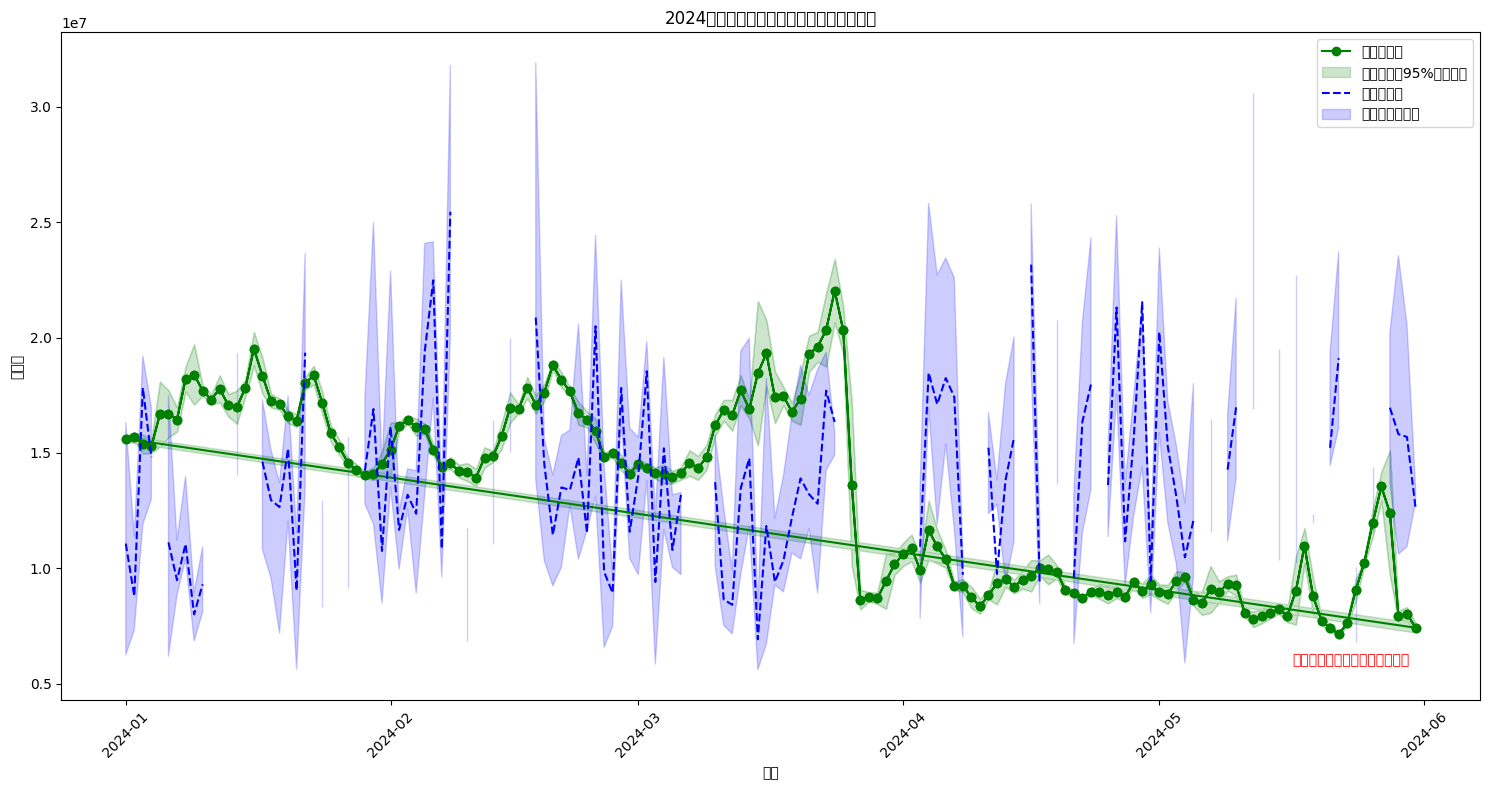

2024年预测结果与实际数据的对比统计：
               mean  predicted_mean
count  3.040000e+02    1.070000e+02
mean   1.328210e+07    1.406973e+07
std    3.882136e+06    3.976631e+06
min    7.152174e+06    6.926085e+06
25%    9.240530e+06    1.099717e+07
50%    1.419167e+07    1.360889e+07
75%    1.670417e+07    1.645568e+07
max    2.203333e+07    2.546691e+07
2024年均方根误差（RMSE）：6080959.5915
2024年相关系数：-0.2094


In [13]:
# 将预测结果转换为DataFrame
predicted_df = pd.DataFrame({
    'date': dates,
    'predicted_mean': estimated_densities_mean,
    'predicted_lower': estimated_densities_lower,
    'predicted_upper': estimated_densities_upper
})
predicted_df.set_index('date', inplace=True)

# 合并实际数据和预测数据
combined_df = pd.concat([daily_stats, predicted_df], axis=1)

# 筛选2024年的数据
combined_df_2024 = combined_df[combined_df.index.astype(str).str.startswith('2024')]

# 绘制2024年的对比图
plt.figure(figsize=(15, 8))

# 绘制实际数据
plt.plot(combined_df_2024.index, combined_df_2024['mean'], label='实际藻密度', color='green', marker='o')
plt.fill_between(combined_df_2024.index, combined_df_2024['lower_ci'], combined_df_2024['upper_ci'], 
                 alpha=0.2, color='green', label='实际藻密度95%置信区间')

# 绘制预测数据
plt.plot(combined_df_2024.index, combined_df_2024['predicted_mean'], label='预测藻密度', color='blue', linestyle='--')
plt.fill_between(combined_df_2024.index, combined_df_2024['predicted_lower'], combined_df_2024['predicted_upper'], 
                 alpha=0.2, color='blue', label='预测藻密度范围')

plt.xlabel('日期')
plt.ylabel('藻密度')
plt.title('2024年太湖藻密度预测结果与实际数据对比 (LSTM模型)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# 添加说明
plt.text(0.95, 0.05, '缺失数据表示云覆盖或处理错误', transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='bottom', color='red')

plt.show()

# 输出一些统计信息
print("2024年预测结果与实际数据的对比统计：")
print(combined_df_2024[['mean', 'predicted_mean']].describe())

# 计算均方根误差（RMSE）
rmse = np.sqrt(((combined_df_2024['mean'] - combined_df_2024['predicted_mean']) ** 2).mean())
print(f"2024年均方根误差（RMSE）：{rmse:.4f}")

# 计算相关系数
correlation = combined_df_2024['mean'].corr(combined_df_2024['predicted_mean'])
print(f"2024年相关系数：{correlation:.4f}")


特征重要性:
  feature  importance_mean  importance_lower  importance_upper
1    ndvi         0.205677          0.170546          0.242510
0    ndci         0.151275          0.163036          0.136977
3    ndwi         0.149900          0.196176          0.140572
2     evi         0.132924          0.126826          0.133723
4      b1         0.127442          0.111030          0.130865
6      b5         0.127053          0.118319          0.112119
5      b2         0.105730          0.114067          0.103234


/tmp/ipykernel_11836/1651507804.py:18: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/1651507804.py:18: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/1651507804.py:18: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/1651507804.py:18: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/1651507804.py:18: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/1651507804.py:18: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11836/1651507804.py:18: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  plt.

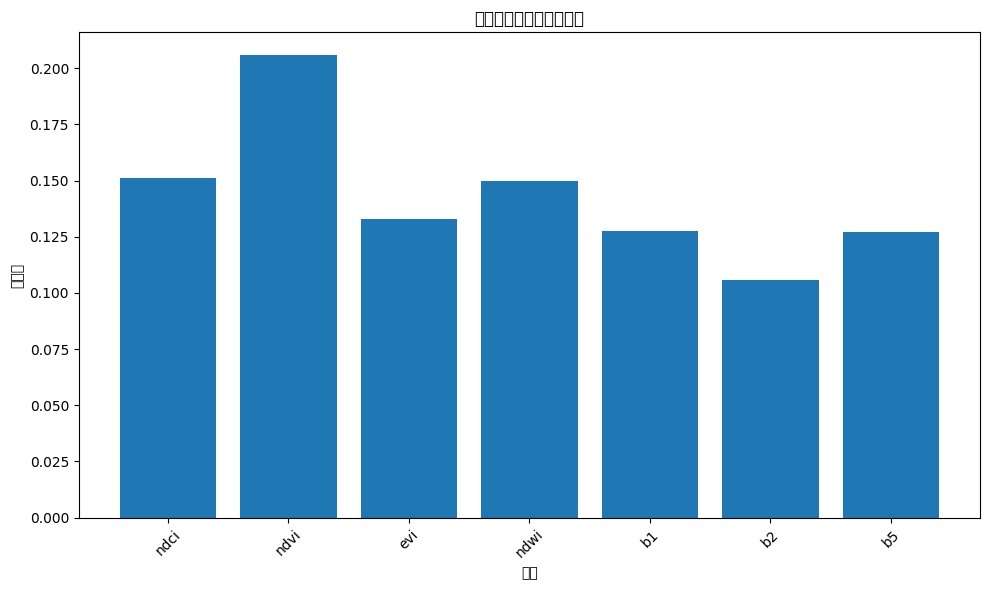

随机森林模型应用完成
藻密度估算已完成


In [14]:

# 步骤6: LSTM模型评估
print("LSTM模型评估:")

# 计算均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"均方根误差（RMSE）：{rmse:.4f}")

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(y_test, y_pred)
print(f"平均绝对误差（MAE）：{mae:.4f}")

# 计算R方值
r2 = r2_score(y_test, y_pred)
print(f"R方值：{r2:.4f}")

# 绘制预测值与实际值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('LSTM模型预测值与实际值对比')
plt.tight_layout()
plt.show()

# 输出模型结果
print("LSTM模型应用完成")
print("藻密度估算已完成")